<a href="https://colab.research.google.com/github/linhlinhle997/object-detection-techniques/blob/features%2Fod-part1/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Classification

In [1]:
import kagglehub
import shutil
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models.resnet import ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Download dataset

In [2]:
dataset = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
data_dir = "/content/dog-and-cat-detection"
shutil.move(dataset, data_dir)

100%|██████████| 1.03G/1.03G [00:10<00:00, 104MB/s]

Extracting files...


'/content/dog-and-cat-detection'

In [3]:
!cat /content/dog-and-cat-detection/annotations/Cats_Test736.xml


<annotation>
    <folder>images</folder>
    <filename>Cats_Test736.png</filename>
    <size>
        <width>500</width>
        <height>466</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>cat</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>49</xmin>
            <ymin>125</ymin>
            <xmax>111</xmax>
            <ymax>168</ymax>
        </bndbox>
    </object>
    <object>
        <name>cat</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>397</xmin>
            <ymin>103</ymin>
            <xmax>451</xmax>
            <ymax>132</ymax>
        </bndbox>
    </object>
</annotation>

## Dataset and DataLoader Setup

In [4]:
class ImageDataset(Dataset):
    def __init__(self, annotation_dir, image_dir, transform=None):
        self.annotation_dir = annotation_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects() # Filter valid images

    def filter_images_with_multiple_objects(self):
        valid_images_files = []
        for image_name in os.listdir(self.image_dir):
            # Check if it's a file and get the corresponding annotation file
            if os.path.isfile(os.path.join(self.image_dir, image_name)):
                annotation_name = os.path.splitext(image_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotation_dir, annotation_name)

            # Add image if it has <=1 object
            if self.count_objects_in_annotation(annotation_path) <= 1:
                valid_images_files.append(image_name)
            else:
                print(f"{image_name} has more than one object.")
        return valid_images_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            # Parse XML and count objects
            tree = ET.parse(annotation_path)
            return len(tree.getroot().findall("object"))
        except FileNotFoundError:
            return 0

    def parse_annotation(self, annotation_path):
        # Parse XML to extract object label
        tree = ET.parse(annotation_path)
        label = next((obj.find("name").text for obj in tree.getroot().findall("object")), None)

        # Map label to numeric value
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1
        return label_num

    def __len__(self):
        return len(self.image_files) # Total number of valid images

    def __getitem__(self, idx):
        # Get image path and load it
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Get annotation path and parse label
        annotation_name = os.path.splitext(image_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotation_dir, annotation_name)
        label = self.parse_annotation(annotation_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Data directory
annotation_dir = os.path.join(data_dir, "annotations")
image_dir = os.path.join(data_dir, "images")

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({"image_name": image_files})
df.head()

,image_name
0,Cats_Test2285.png
1,Cats_Test1306.png
2,Cats_Test1098.png
3,Cats_Test1490.png
4,Cats_Test137.png


In [6]:
# Train - Val split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.shape, val_df.shape

((2948, 1), (738, 1))

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(
    annotation_dir,
    image_dir,
    transform=transform
)

val_dataset = ImageDataset(
    annotation_dir,
    image_dir,
    transform=transform
)

Cats_Test736.png has more than one object.
Cats_Test736.png has more than one object.


In [8]:
# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df["image_name"].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df["image_name"].values]

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

len(train_loader), len(val_loader)

(93, 24)

## Model

In [9]:
# Model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Show model summary
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training and Evaluation Metrics Visualization


In [10]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    correct, total = 0, 0
    losses = []
    model.train()
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predictions = scores.max(1)
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

    avg_loss = np.mean(losses)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


def evalute(model, val_loader, criterion, device):
    losses = []
    correct, total = 0, 0
    model.eval()

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)

            scores = model(data)
            loss = criterion(scores, targets)
            losses.append(loss.item())

            _, predictions = scores.max(1)
            correct += (predictions == targets).sum().item()
            total += targets.size(0)

    avg_loss = np.mean(losses)
    accuracy = 100.0 *correct / total
    return avg_loss, accuracy

In [11]:
num_epochs = 10
train_losses, val_losses = [], []
train_acces, val_acces = [], []

for epoch in range(num_epochs):
    # Train and Evaluation model
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evalute(model, val_loader, criterion, device)

    # Log metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acces.append(train_acc)
    val_acces.append(val_acc)

    # Print metrics for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/10: Train Loss: 0.2210, Train Acc: 90.88%, Val Loss: 0.5338, Val Acc: 86.70%
Epoch 2/10: Train Loss: 0.0902, Train Acc: 96.91%, Val Loss: 0.3057, Val Acc: 88.87%
Epoch 3/10: Train Loss: 0.0583, Train Acc: 97.83%, Val Loss: 0.2075, Val Acc: 93.76%
Epoch 4/10: Train Loss: 0.0684, Train Acc: 97.32%, Val Loss: 0.1088, Val Acc: 95.79%
Epoch 5/10: Train Loss: 0.0633, Train Acc: 97.93%, Val Loss: 0.1759, Val Acc: 94.03%
Epoch 6/10: Train Loss: 0.0442, Train Acc: 98.20%, Val Loss: 0.1558, Val Acc: 93.62%
Epoch 7/10: Train Loss: 0.0993, Train Acc: 96.57%, Val Loss: 0.1659, Val Acc: 93.62%
Epoch 8/10: Train Loss: 0.0294, Train Acc: 98.95%, Val Loss: 0.2513, Val Acc: 91.99%
Epoch 9/10: Train Loss: 0.0671, Train Acc: 97.90%, Val Loss: 0.2103, Val Acc: 90.77%
Epoch 10/10: Train Loss: 0.0284, Train Acc: 98.98%, Val Loss: 0.1109, Val Acc: 96.07%


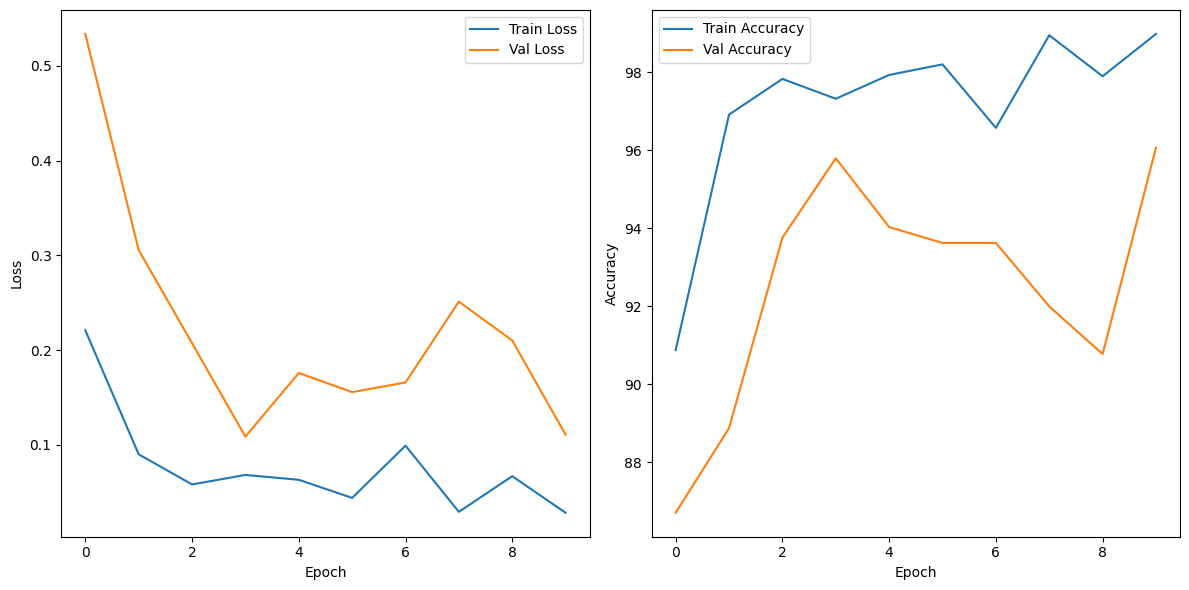

In [12]:
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acces, label="Train Accuracy")
plt.plot(val_acces, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Inference

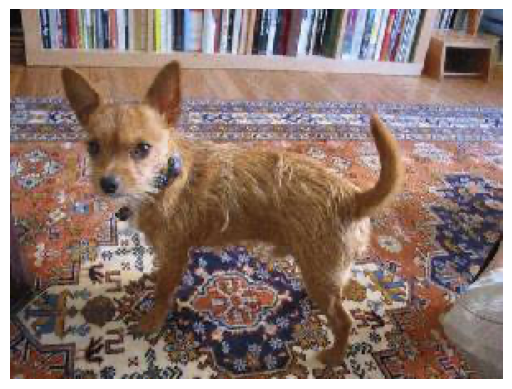

True Label: 1, Predicted Label: 1


In [17]:
def predict(model, val_dataset, device):
    """Predict the label of a randomly selected image from the validation dataset."""
    # Randomly select an image from the dataset
    random_idx = random.randint(0, len(val_dataset) - 1)
    image_name = val_dataset.image_files[random_idx]
    image_name = os.path.join(image_dir, image_name)

    # Display the selected image
    original_image = Image.open(image_name)
    plt.imshow(original_image)
    plt.axis("off")
    plt.show()

    # Prepare the image and label
    image, label = val_dataset[random_idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension (1, C, H, W)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        scores = model(image)

        # Get the predicted class label
        _, pred_label = scores.max(1) # max(1) gives the index of the highest score

    print(f"True Label: {label}, Predicted Label: {pred_label.item()}")
    return pred_label.item()

predicted_label = predict(model, val_dataset, device)